In [5]:
# configuration
from mlxtend.feature_selection import ColumnSelector
from sklearn.preprocessing import LabelEncoder
config = {
    'FILE_PATH': '/Users/pradeep/Desktop/ProjectANotebooks/notebooks/cleaned_incidents1.csv'
    }

# imports
import warnings
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import string
import re
from time import time
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import texthero as hero
import matplotlib
from texthero import preprocessing
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from yellowbrick.model_selection import LearningCurve
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import ClassPredictionError
from mlxtend.plotting import plot_learning_curves
from yellowbrick.classifier import ClassificationReport
from sklearn.metrics import f1_score, recall_score
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report
from sklearn.pipeline import Pipeline

# global settings
plt.style.use('classic')
matplotlib.rcParams['figure.figsize'] = (20, 10)
# ignore warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

# set seeds for reproducability
from numpy.random import seed
seed(500)

# global configurations
pd.set_option("display.max_colwidth", -1)

In [6]:
# columns that we use
cols = ['EventDescription','IncidentCause','IncidentConsequence','Category']

# importing file
df = pd.read_csv(config['FILE_PATH'], usecols=cols)

# drop missing category
df = df.dropna(axis=0, subset=['Category'])

# replace the rest with empty string
df = df.replace(np.nan, '', regex=True)

In [7]:
# Text Cleaning and Pre-processing
def preprocess_text(features):
    # cleaning steps
    cleaning_pipeline = [
        preprocessing.fillna,
        preprocessing.lowercase,
        preprocessing.remove_whitespace,
        preprocessing.remove_punctuation,
        preprocessing.remove_urls,
        preprocessing.remove_brackets,
        preprocessing.remove_stopwords,
        preprocessing.remove_digits,
        preprocessing.remove_angle_brackets,
        preprocessing.remove_curly_brackets,
        preprocessing.stem
    ]

    # apply pipeline to text
    clean_text = features.pipe(hero.clean, cleaning_pipeline)

    return clean_text

In [8]:
# cleaning the data
df['description'] = df['EventDescription'] + ' ' + df['IncidentCause']+ ' ' + df['IncidentConsequence']
df['description'] = preprocess_text(df['description'])

le = LabelEncoder()
Y = le.fit_transform(df['Category'])

# splitting of data in test and train
x_train,x_test, y_train, y_test = train_test_split(df['description'],Y, test_size=0.25, random_state = 42)

# vectorize
tfidf = TfidfVectorizer(analyzer='word', max_features=10000)

tfidf.fit_transform(df['description']).toarray()

# dump tfidf
pickle.dump(tfidf, open('TFIDF_10000.pickle', 'wb'))

x_train = tfidf.transform(x_train)
x_test = tfidf.transform(x_test)

# resampling
oversample = SMOTE(random_state=0,n_jobs=-1,k_neighbors=5, sampling_strategy='auto')
x_train, y_train = oversample.fit_resample(x_train, y_train)

In [9]:
# Voting classifier with TFIDF
classifiers = [
    ('rf', RandomForestClassifier(random_state=0, n_estimators=800, max_depth=20, min_samples_leaf=50, max_features='sqrt', criterion='gini', n_jobs=-1)),
    #('sgd', SGDClassifier(random_state=0, alpha=0.001, loss='log', max_iter=1000, penalty='elasticnet', n_jobs=-1)),
    ('lr', LogisticRegression(random_state=0, max_iter= 130, C=1, penalty='l2'))
    #('svc', SVC(C=10.0, kernel = 'linear', tol=0.001, probability=True)),
    #('xgb', XGBClassifier(random_state=4, early_stopping_rounds=10))
]

voting_clf = VotingClassifier(estimators=classifiers, voting='soft', n_jobs=-1)
# fit
voting_clf.fit(x_train, y_train)

# dump tfidf
pickle.dump(voting_clf, open('voting.pickle', 'wb'))

# predict
y_pred = voting_clf.predict(x_test)

# accuracy
print(accuracy_score(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# F-measure
from sklearn.metrics import f1_score
f1score = f1_score(y_test, y_pred, average='micro')
print(f'F-Measure: {f1score}')

0.8102279728897104
Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.57      0.52        87
           1       0.93      0.83      0.87        75
           2       0.49      0.57      0.53        51
           3       0.80      0.77      0.79       232
           4       0.86      0.83      0.85       121
           5       0.86      0.96      0.91        90
           6       0.90      0.83      0.86       106
           7       0.56      0.56      0.56         9
           8       0.93      0.71      0.81        35
           9       0.58      0.72      0.64        58
          10       0.94      0.85      0.89       349
          11       0.59      0.63      0.61        73
          12       0.86      0.92      0.89       144
          13       0.22      0.40      0.29         5
          14       0.90      0.90      0.90       188

    accuracy                           0.81      1623
   macro avg       0.73      0.74    

In [10]:
plt.style.use('classic')
matplotlib.rcParams['figure.figsize'] = (20, 10)

# evaluation metrics for imbalanced data
def model_evaluation(model, x_train, y_train, x_test, y_test, model_name, y_pred):
    """:arg
    :model, classifier, must have .fit() and .predict()
    :x_train, X, features
    :y_train, y, target
    :x_test, test features
    :y_test, test target
    :model_name, name of the classifier, string
    :y_pred, prediction made by classifier
    """

    # constants
    sizes = np.linspace(0.3, 1.0, 10)

    # accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f'The accuracy for {model_name}: {acc}')

    # F-measure
    f1score = f1_score(y_test, y_pred, average='micro')
    print(f'F-Measure for {model_name}: {f1score}')

    target_names = le.classes_

    # classification report
    visualizer = ClassificationReport(model, support=True, cmap='spectral', classes = target_names)
    visualizer.fit(x_train, y_train)        # Fit the visualizer and the model
    visualizer.score(x_test, y_test)        # Evaluate the model on the test data
    visualizer.show()

    # Generate confusion matrix
    matrix = plot_confusion_matrix(model, x_test, y_test, cmap=plt.cm.Blues, display_labels=target_names)
    plt.title(f'Confusion matrix for {model_name} classifier')
    plt.xticks(rotation=65)
    plt.show(matrix)
    plt.show()

    # precision recall curve
    viz = PrecisionRecallCurve(
        model,
        cmap="Set1",
        train_sizes=sizes,
        per_class=True,
        classes=target_names,
        colors=["purple", "cyan", "slategray", "red", "grey", "yellow", "maroon", "gold", "orange", "olive", "brown", "deeppink", 'darkkhaki', "black", "navy"]
    )
    viz.fit(x_train, y_train)
    viz.score(x_test, y_test)
    viz.show()

    # class prediction error
    visualizer = ClassPredictionError(
        model,
        classes=target_names,
        colors=["purple", "cyan", "slategray", "red", "grey", "yellow", "maroon", "gold", "orange", "olive", "brown", "deeppink", 'darkkhaki', "black", "navy"]
    )
    visualizer.fit(x_train, y_train)
    visualizer.score(x_test, y_test)
    visualizer.show()

    # Create the learning curve visualizer
    cv = StratifiedKFold(n_splits=10)
    visualizer = LearningCurve(
        model, cv=cv, scoring='f1_micro', train_sizes=sizes, n_jobs=4
    )
    visualizer.fit(x_train, y_train)
    visualizer.show()

    # learning curve with train and test data
    plot_learning_curves(x_train, y_train, x_test, y_test, model, train_marker='o', test_marker='^',
                     scoring='misclassification error', suppress_plot=False, print_model=False, legend_loc='best')


The accuracy for Voting: 0.8102279728897104
F-Measure for Voting: 0.8102279728897104


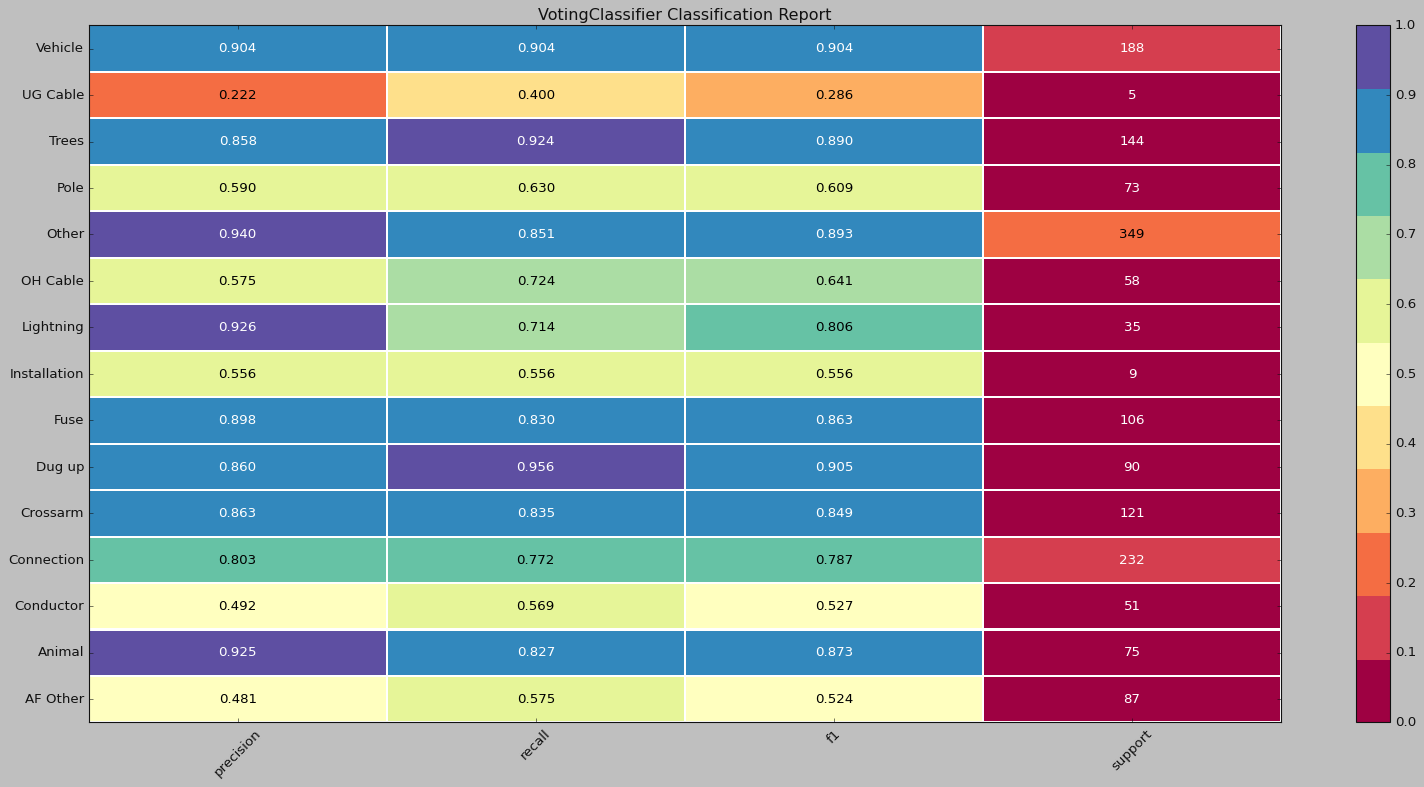

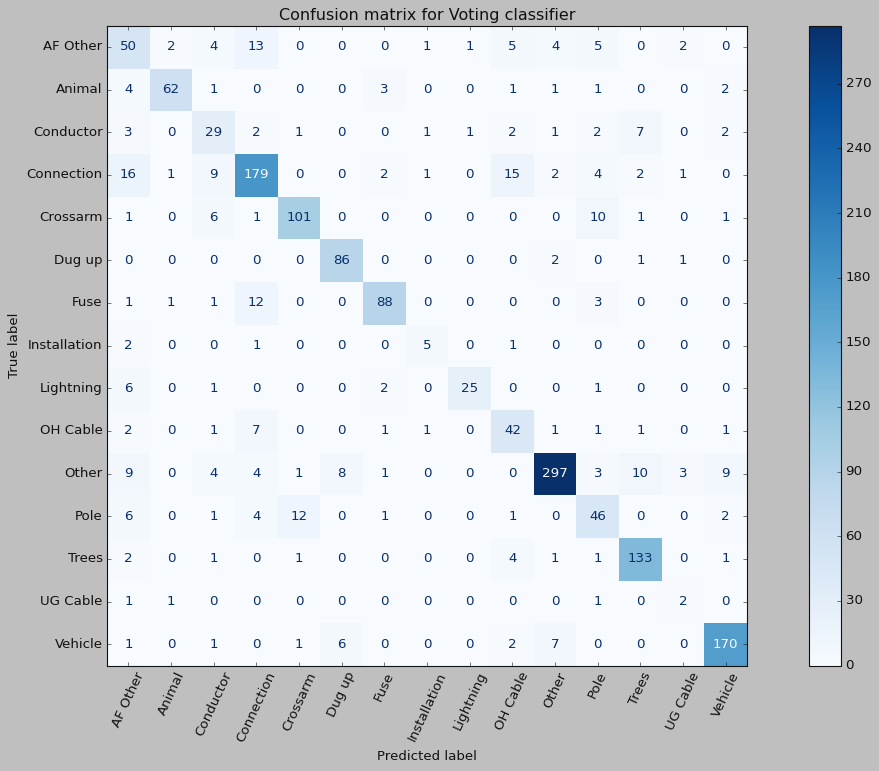

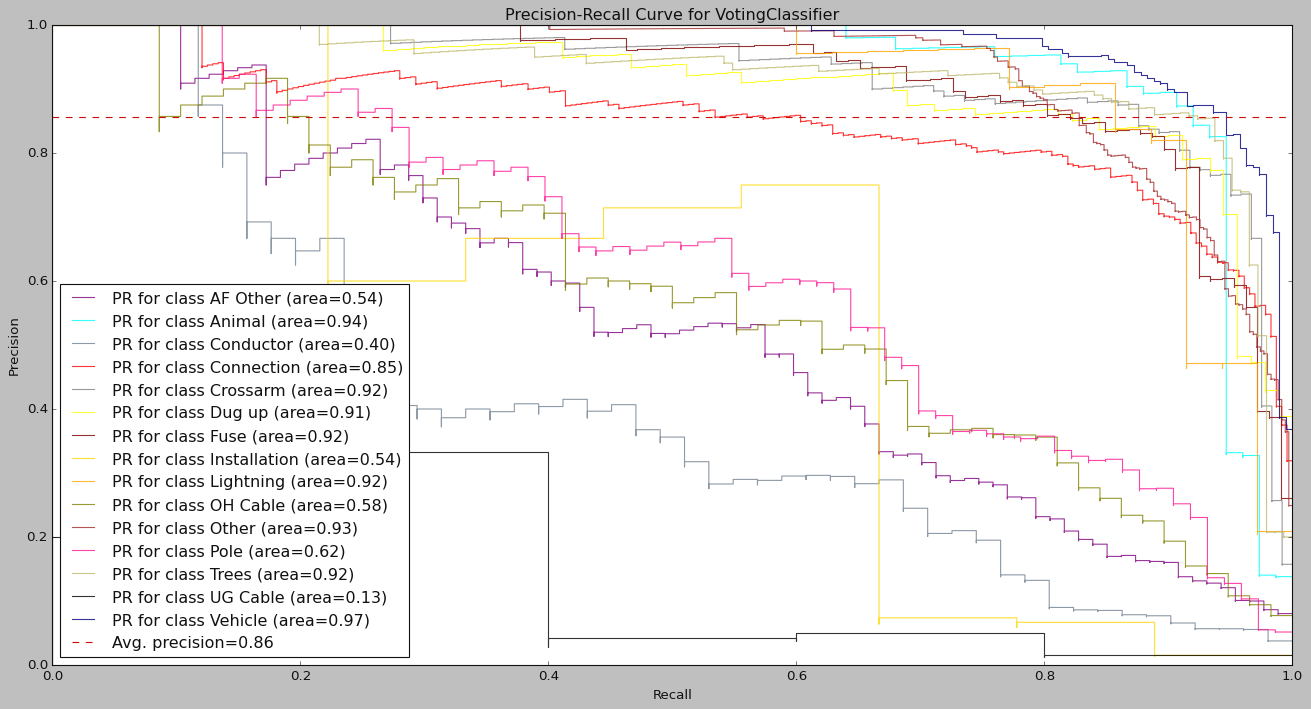

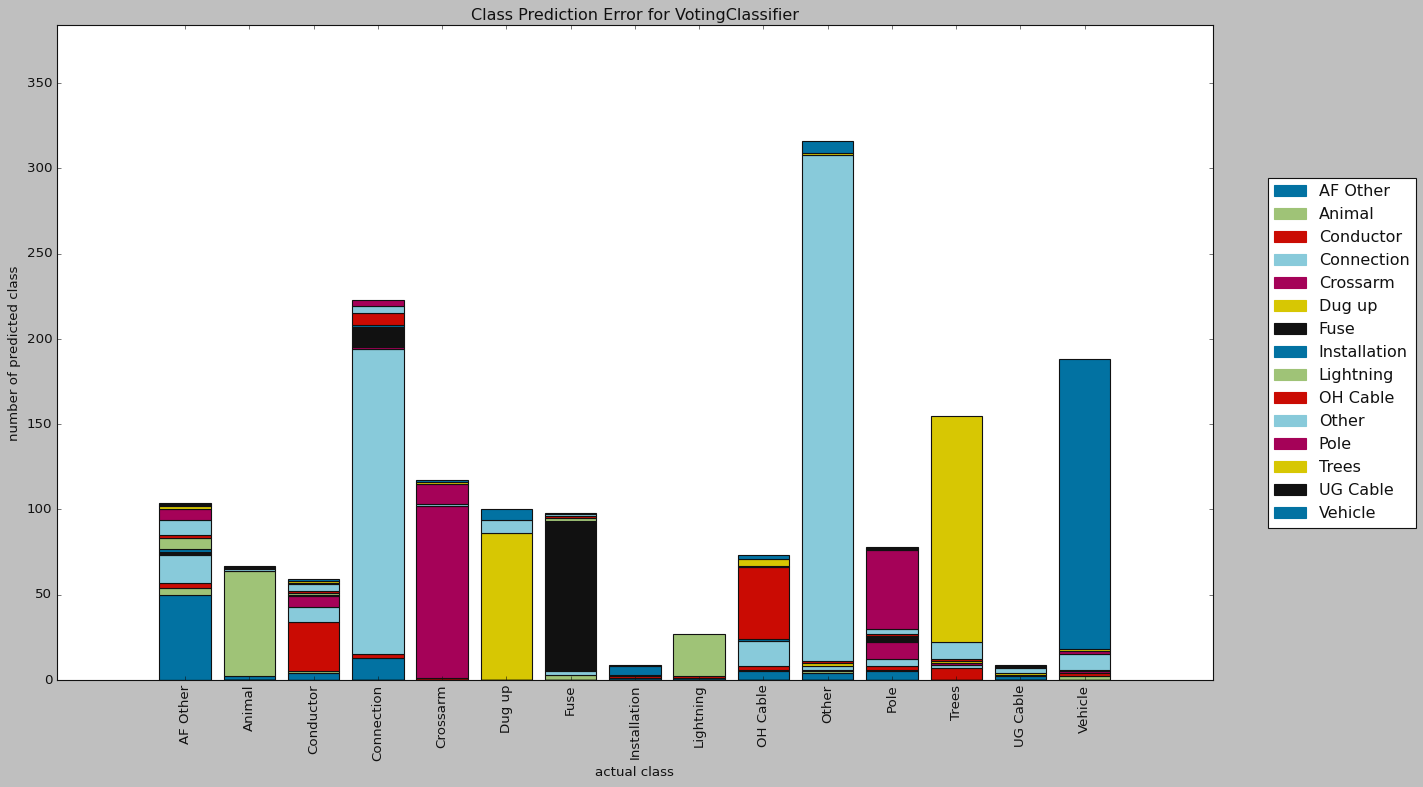

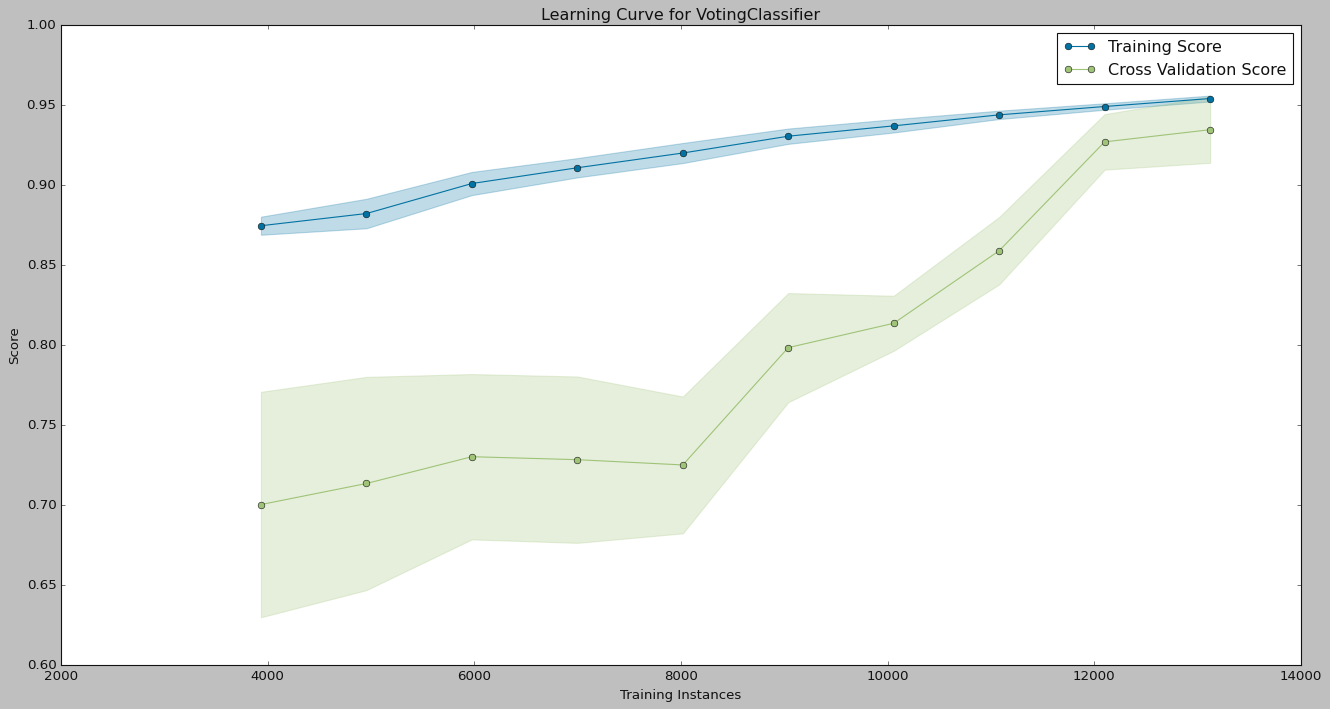

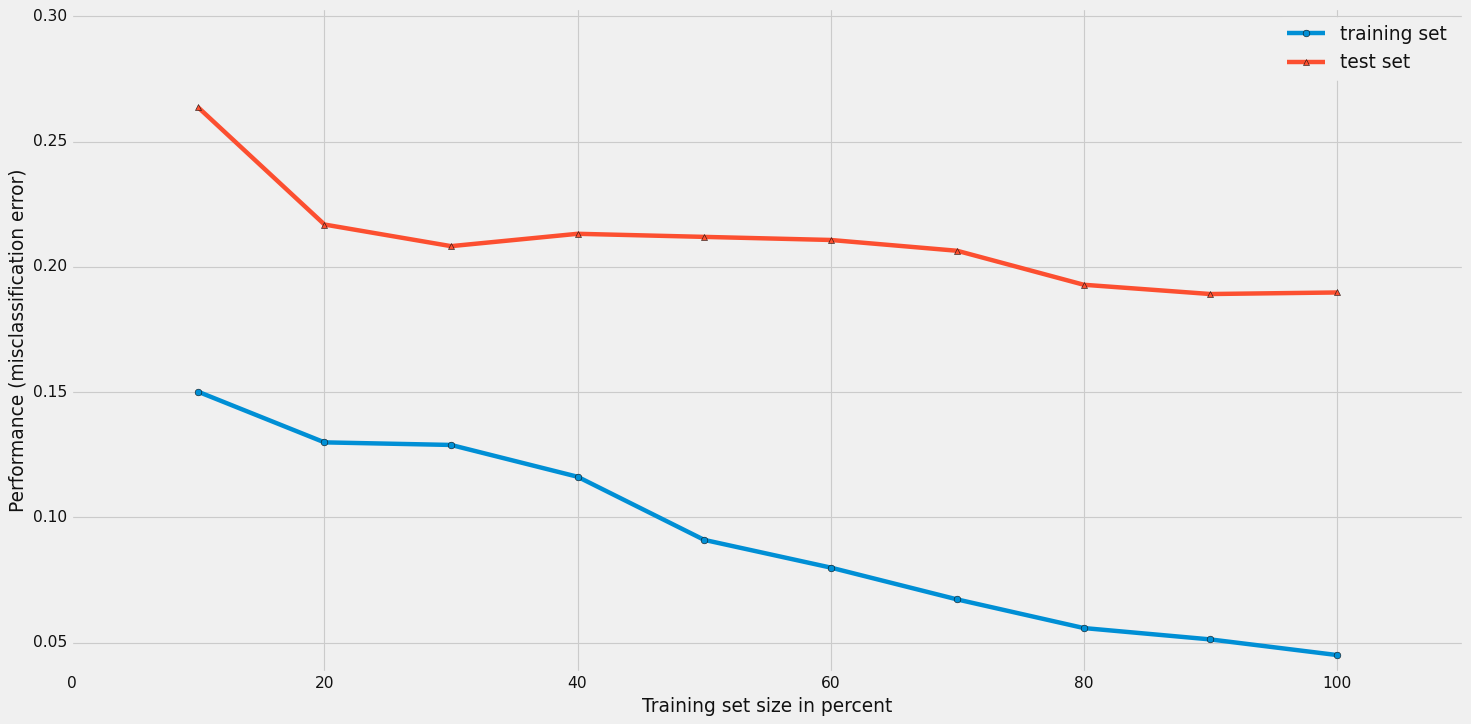

In [11]:
model_evaluation(voting_clf, x_train, y_train, x_test, y_test, 'Voting', y_pred)